# Example: Single XB conversion at UH

In [1]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import torch_func
from diff_func_fitters import fit_polynomial, fit_rational_func, SumFunc, FiniteDiffFunc1D
from gauss_freud_quad import get_nodes_and_weights
from scipy.optimize import brentq
from baryrat import aaa

import mgo

In [2]:
# Define Warm Plasma Dispersion Relation
import torch
from scipy.constants import e, m_e, epsilon_0, c

# ICs
f0 = 105e9
omega0 = 2*np.pi*f0

# Constants
n0 = 5.4e19
T0 = 300*e
L_ne = 27e-3
B0 = 3.35

@torch_func
def B(x: ('scalar')):
    return B0 * torch.ones_like(x)

@torch_func
def omega_c(x: ('scalar')):
    return e*B(x)/m_e

@torch_func
def T_e(x: ('scalar')):
    return T0

@torch_func
def n_e(x: ('scalar')):
    return n0 * (1 - x/L_ne)

@torch_func
def omega_p_squared(x: ('scalar')):
    return n_e(x) * e**2 / (epsilon_0 * m_e)

@torch_func
def v_Te_squared(x: ('scalar')):
    return 2*T_e(x)/m_e

@torch_func
def Stix_S(x: ('scalar'), omega: ('scalar')):
    return 1 - (omega_p_squared(x)/(omega**2 - (omega_c(x)**2 )))

@torch_func
def Stix_D(x: ('scalar'), omega: ('scalar')):
    return (omega_c(x)/omega) * (omega_p_squared(x)/(omega**2 - (omega_c(x)**2)))

@torch_func
def lamb(x: ('scalar'), k: ('scalar')):
    return v_Te_squared(x)/(2 * (omega_c(x)**2)) * (torch.abs(k)**2)

@torch_func
def Omega(x: ('scalar'), omega: ('scalar')):
    return omega/omega_c(x)

@torch_func
def K1_int(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    _psi = torch.linspace(0, torch.pi, 100)
    return (torch.exp(-lamb(x, k))
            * torch.trapezoid(
            (torch.sin(torch.outer(_psi, Omega(x, omega).reshape(-1)))
                * torch.outer(torch.sin(_psi), torch.ones_like(x.reshape(-1)))
                * torch.exp(
                    - torch.outer(torch.cos(_psi), lamb(x, k).reshape(-1))
                    )
            ), _psi, dim=0)
            )

@torch_func
def K1(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return ((torch.sin(torch.pi * Omega(x, omega)))
     + (omega_p_squared(x)/(omega_c(x)**2))
        * (K1_int(x, k, omega))
    )

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return ((c/omega)**2 *
            (K1(x, k, omega) * (torch.abs(k)**2)
             - (torch.sin(torch.pi * Omega(x, omega)))*(omega/c)**2 *
             (Stix_S(x, omega)**2 - Stix_D(x, omega)**2)))

def D_vec(x, k, omega):
    return D(x.flatten(), k.flatten(), omega.flatten()).reshape(x.shape)

def get_k0(x0, omega0, kmin, kmax):
    return brentq(lambda k: D(x0, k, omega0), kmin, kmax)

#### Test Dispersion on a $(x, k, \omega)$ point

In [3]:
k0 = 10e3
f0 = f0
omega0 = 2*np.pi*f0
x0 = 0

print(
    'B', B(x0),
    '\n omega_c', omega_c(x0),
    '\n n_e', n_e(x0),
    '\n omega_p_squared', omega_p_squared(x0),
    '\n Stix_S', Stix_S(x0, omega0),
    '\n Stix_D', Stix_D(x0, omega0),
    '\n lambd', lamb(x0, k0),
    '\n v_Te_squared', v_Te_squared(x0),
    '\n K1_int', K1_int(x0, k0, omega0),
    '\n K1', K1(x0, k0, omega0),
    '\n D', D(x0, k0, omega0)
)

B tensor(3.3500) 
 omega_c tensor(5.8920e+11) 
 n_e tensor(5.4000e+19) 
 omega_p_squared tensor(1.7186e+23) 
 Stix_S tensor(-0.9510) 
 Stix_D tensor(1.7424) 
 lambd tensor(0.0152) 
 v_Te_squared 105529200646329.78 
 K1_int tensor([1.4236]) 
 K1 tensor([0.3375]) 
 D tensor([6.1859])


In [4]:
# omega_T = torch.tensor(omega0, requires_grad=True)
# x_T = torch.tensor(float(x0), requires_grad=True)
# k_T = torch.tensor(float(k0), requires_grad=True)
# D_test = D(x_T, k_T, omega_T)

# D_test.backward()
# grad_x = x_T.grad
# grad_k = k_T.grad
# RHS_x = - grad_k
# RHS_k = grad_x

#### Plot Dispersion in $(k, f)$ space

In [5]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

k0 3300.782889935932  m^-1


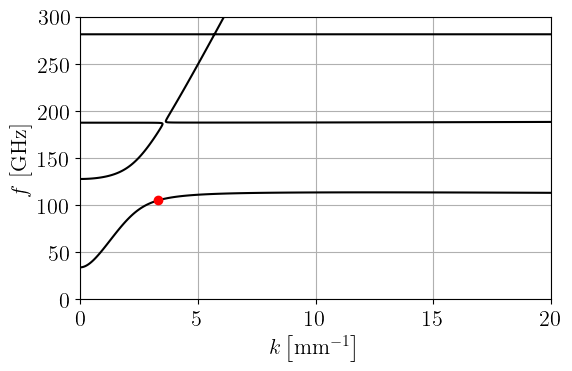

In [6]:
f0 = f0
omega0 = 2*np.pi*f0
x0 = 0e-3
ki = np.linspace(0, 20e3, 1000)
omegai = 2*np.pi*np.linspace(1e-6, 300e9, 1000)
K, O = np.meshgrid(ki, omegai, indexing='ij')

k0 = get_k0(x0, omega0, 0, 10000)
print('k0', k0, ' m^-1')

plt.figure(figsize=(6, 4))
plt.contour(K * 1e-3, O/(2*np.pi) * 1e-9, D_vec(x0*np.ones_like(K), K, O), levels=[0], colors=['k'])
# plt.plot(plt.gca().get_xlim(), [f0 * sc_omega * 1e-9, f0 * sc_omega * 1e-9], '--', linewidth=1)
plt.plot(k0*1e-3, f0 * 1e-9, 'ro')
plt.ylabel(r'$f$ [GHz]')
plt.xlabel(r'$k \, \mathrm{\left[ mm^{-1} \right]}$')
# plt.plot(ki * 1e-3, f0*np.ones_like(ki) * 1e-9, 'r-')
plt.tight_layout()
plt.grid()
# plt.savefig('./plots/Trapped_UH_dispersion.pdf')
# plt.savefig('./plots/Trapped_UH_dispersion.png', dpi=600)
plt.show()

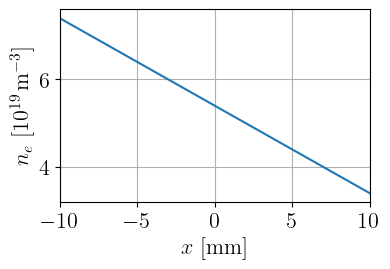

In [7]:
xi = np.linspace(-10e-3, 10e-3, 200)

plt.figure(figsize=(4,2.5))
plt.plot(xi*1e3, n_e(xi)*1e-19)
# plt.plot([0, 16], [omega0*1e-9, omega0*1e-9])
# plt.plot(xi, omega_c(xi)*1e-9)
# plt.plot(xi, np.sqrt(omega_p_squared(xi))*1e-9)
plt.xlim(-10, 10)
plt.xlabel('$x$ [mm]')
plt.ylabel(r'$n_e$ [$10^{19} \, \mathrm{m^{-3}}$]')
plt.grid()
plt.show()

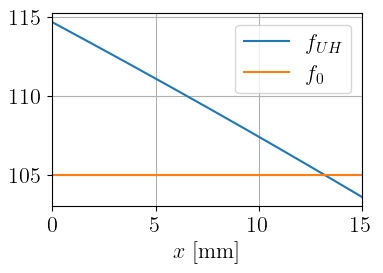

In [8]:
xi = np.linspace(0e-3, 15e-3, 200)

plt.figure(figsize=(4,2.5))
plt.plot(xi*1e3, np.sqrt(omega_c(xi)**2 + omega_p_squared(xi))/(2*np.pi)*1e-9, label=r'$f_{{UH}}$')
plt.plot(xi*1e3, omega0*np.ones_like(xi)/(2*np.pi)*1e-9, label=r'$f_0$')
# plt.plot([0, 16], [omega0*1e-9, omega0*1e-9])
# plt.plot(xi, omega_c(xi)*1e-9)
# plt.plot(xi, np.sqrt(omega_p_squared(xi))*1e-9)
plt.xlim(0, 15)
plt.xlabel('$x$ [mm]')
plt.legend()
plt.grid()
plt.show()

In [9]:
max_gauss_quad_order = 3

def get_dispersion_manifold(x0, k0, omega0):
    ND = 1
    nt = 6000
    t, xs, ks, zs, i_start, i_end = trace_ray_1D(x0=x0, k0=k0, omega0=omega0, tmin=0, tmax=30e-9, D=D, x_min = x0, tsteps=nt, ghost_ratio=0.01, solve_ivp_args={'method': 'LSODA'}, true_time=True, rtol=1e-9)
    nt = i_end - i_start
    return t, xs, ks, zs, nt, i_start, i_end, x0, k0

def get_mgo_field(phi0, t, zs, i_start, i_end, i_save=[],
                       analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 20}},
                       'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 20}}},):
    branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0, i_start, i_end, i_save=i_save, analytic_cont=analytic_cont, max_gauss_quad_order=max_gauss_quad_order)
    results = mgo_info['saved_results']
    Nt = mgo_info['Nt']
    Upsilon = mgo_info['Upsilon']
    return branch_masks, ray_field, mgo_info, results, Nt, Upsilon

In [10]:
t, xs, ks, zs, nt, i_start, i_end, x0, k0 = get_dispersion_manifold(x0, k0, omega0)
S = mgo.get_symplectic_tangent_trfm(zs, t, 1, i_start, i_end)
i_caust = np.argmin(np.abs(S[:, 0, 0]))
i_dt = int(0.2*nt)
i_save = np.arange(i_caust - i_dt, i_caust + i_dt, int(2*i_dt/4))

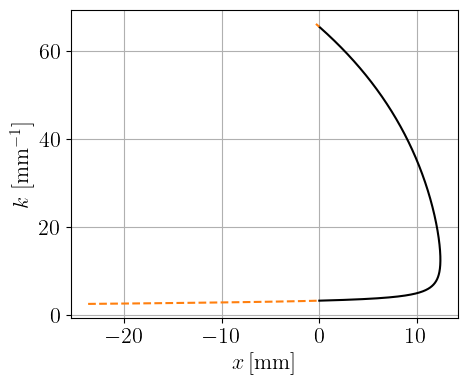

In [11]:
plt.figure(figsize=(5, 4))
plt.plot(xs[i_start:i_end]*1e3, ks[i_start:i_end]*1e-3, color='k')
plt.plot(xs[:i_start]*1e3, ks[:i_start]*1e-3, '--', color='tab:orange')
plt.plot(xs[i_end:]*1e3, ks[i_end:]*1e-3, '--', color='tab:orange')
plt.ylabel(r'$k \,\, [\mathrm{mm^{-1}}]$')
plt.xlabel(r'$x \, [\mathrm{mm}]$')
plt.grid()
plt.show()

In [12]:
phi0 = 1
analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 10}}, 'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 10}}}

mgo_branch_masks, mgo_ray_field, info, results, Nt, Upsilon = get_mgo_field(phi0, t, zs, i_start, i_end, i_save=i_save, analytic_cont=analytic_cont)
mgo_field = mgo.superpose_ray_fields(phi0=phi0, x0=x0+1e-3, xs=xs, branch_masks=mgo_branch_masks, ray_field=mgo_ray_field,
                                     i_start=i_start, i_end=i_end, interpolation_method='baryrat')

In [52]:
go_branch_masks, go_ray_field = mgo.get_go_field_1D(t, zs, phi0, i_start, i_end)
go_field = mgo.superpose_ray_fields(phi0=phi0, x0=x0+1e-4, xs=xs, branch_masks=go_branch_masks, ray_field=go_ray_field, i_start=i_start, i_end=i_end, interpolation_method='baryrat', interpolation_args={'tol': 1e-14})

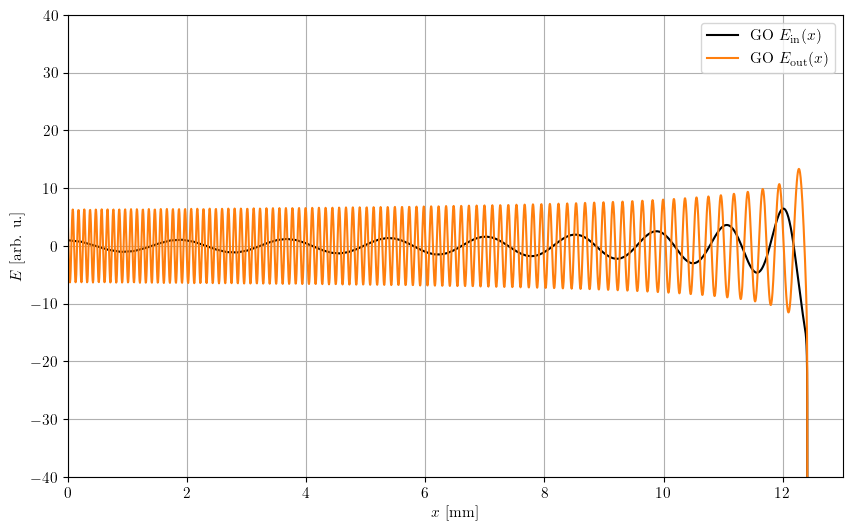

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(xs[i_start:i_start+i_caust]*1e3, np.real(go_ray_field[:i_caust]), '-', color='k', label=r'GO $E_{\mathrm{in}}(x)$')
plt.plot(xs[i_start+i_caust:i_end]*1e3, np.real(go_ray_field[i_caust:]), '-', color='tab:orange', label=r'GO $E_{\mathrm{out}}(x)$')
plt.ylim(-40, 40)
plt.xlim(0,13)
plt.xlabel(r'$x$ [mm]')
plt.ylabel(r'$E$ [arb. u.]')
plt.legend()
plt.grid()
plt.show()

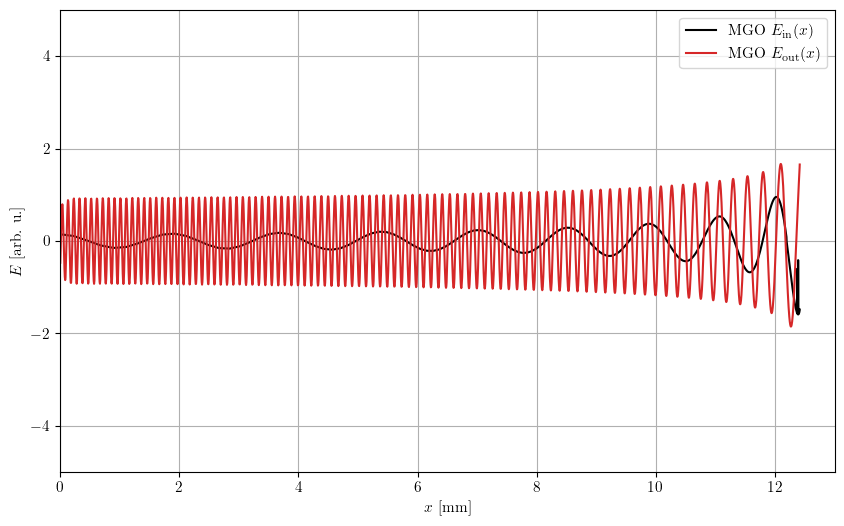

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(xs[i_start:i_start+i_caust]*1e3, 1e3*np.real(mgo_ray_field[:i_caust]), '-', color='k', label=r'MGO $E_{\mathrm{in}}(x)$')
plt.plot(xs[i_start+i_caust:i_end]*1e3, 1e3*np.real(mgo_ray_field[i_caust:]), '-', color='tab:red', label=r'MGO $E_{\mathrm{out}}(x)$')
plt.ylim(-5, 5)
plt.xlim(0,13)
plt.xlabel(r'$x$ [mm]')
plt.ylabel(r'$E$ [arb. u.]')
plt.legend()
plt.grid()
plt.show()

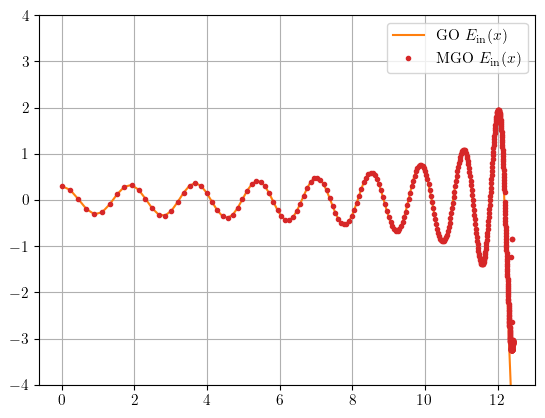

In [86]:
plt.plot(xs[i_start:i_start+i_caust]*1e3, 3e-1*np.real(go_ray_field[:i_caust]), '-', color='tab:orange', label=r'GO $E_{\mathrm{in}}(x)$')
plt.plot(xs[i_start:i_start+i_caust]*1e3, 3e-1*np.real(go_ray_field[0]/mgo_ray_field[0] * mgo_ray_field[:i_caust]), '.', color='tab:red', label=r'MGO $E_{\mathrm{in}}(x)$')
plt.legend()
plt.ylim(-4, 4)
plt.grid()
plt.show()

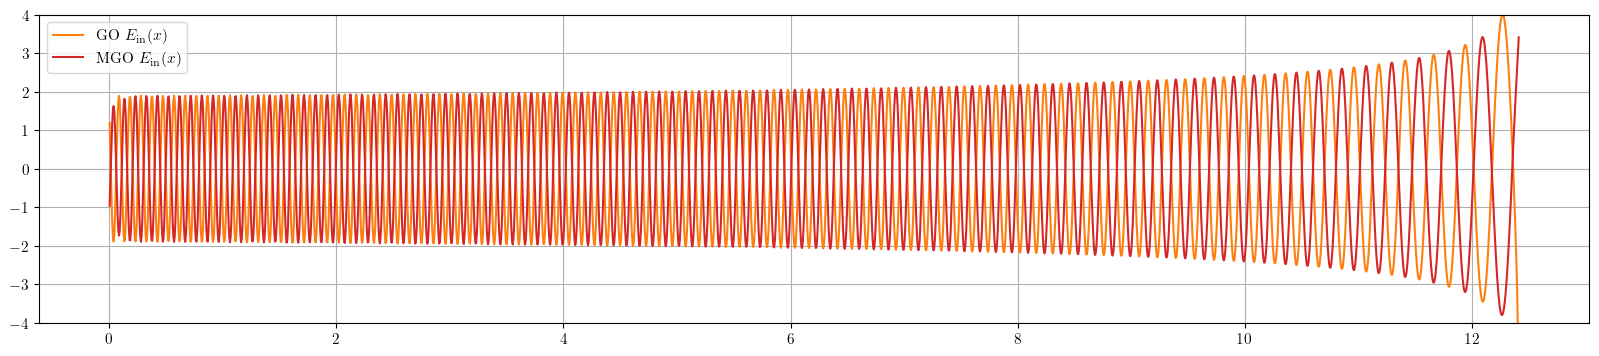

In [88]:
plt.figure(figsize=(20, 4))
plt.plot(xs[i_start+i_caust:i_end]*1e3, 3e-1*np.real(go_ray_field[i_caust:]), '-', color='tab:orange', label=r'GO $E_{\mathrm{in}}(x)$')
plt.plot(xs[i_start+i_caust:i_end]*1e3, 3e-1*np.real(go_ray_field[0]/mgo_ray_field[0] * mgo_ray_field[i_caust:]), '-', color='tab:red', label=r'MGO $E_{\mathrm{in}}(x)$')
plt.legend()
plt.ylim(-4, 4)
plt.grid()
plt.show()

In [55]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 11})
rcParams['axes.titlepad'] = 11

cm = 1/2.54 # 1 cm = 1/2.54 inch

<Figure size 669.291x472.441 with 0 Axes>

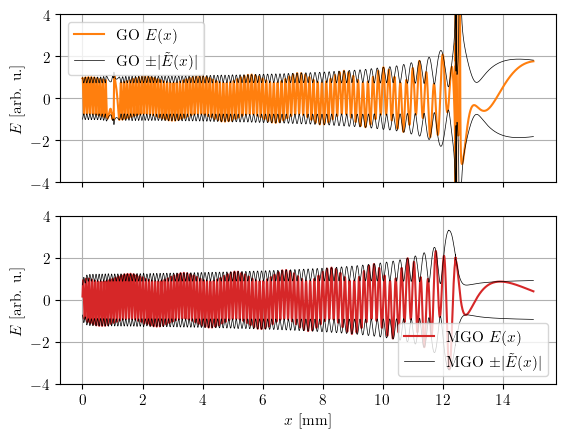

In [89]:
xi = np.linspace(0, 15e-3, 6000)
fig = plt.figure(constrained_layout=True, figsize=(17*cm, 12*cm))

fig, ax = plt.subplots(2, 1)
ax[0].plot(xi*1e3, np.real(go_field(xi)), '-', color='tab:orange', label=r'GO $E(x)$')
ax[0].plot(xi*1e3, np.abs(go_field(xi)), 'k-', linewidth=0.5, label=r'GO $\pm |\tilde{E}(x)|$')
ax[0].plot(xi*1e3, -np.abs(go_field(xi)), 'k-', linewidth=0.5)
ax[0].grid()
ax[0].legend()
# ax[0].set_xlim(0, xs[i_start+i_caust]*1e3)
ax[0].sharex(ax[1])
ax[0].tick_params('x', labelbottom=False)
ax[0].set_ylim(-4, 4)
ax[0].set_ylabel(r'$E$ [arb. u.]')

ax[1].plot(xi*1e3, np.real(mgo_field(xi)), color='tab:red', label=r'MGO $E(x)$')
ax[1].plot(xi*1e3, np.abs(mgo_field(xi)), 'k-', linewidth=0.5, label=r'MGO $\pm |\tilde{E}(x)|$')
ax[1].plot(xi*1e3, -np.abs(mgo_field(xi)), 'k-', linewidth=0.5)
ax[1].grid()
ax[1].legend()
# ax[1].set_xlim(0, xs[i_start+i_caust]*1e3)
ax[1].set_ylim(-4, 4)
ax[1].set_xlabel(r'$x$ [mm]')
ax[1].set_ylabel(r'$E$ [arb. u.]')

plt.show()

In [ ]:
go_field_lin = mgo.superpose_ray_fields(phi0=phi0, x0=x0+1e-3, xs=xs, branch_masks=go_branch_masks, ray_field=go_ray_field,
                                     i_start=i_start, i_end=i_end, interpolation_method='linear')
mgo_field_lin = mgo.superpose_ray_fields(phi0=phi0, x0=x0+1e-3, xs=xs, branch_masks=mgo_branch_masks, ray_field=mgo_ray_field,
                                     i_start=i_start, i_end=i_end, interpolation_method='linear')

<Figure size 669.291x472.441 with 0 Axes>

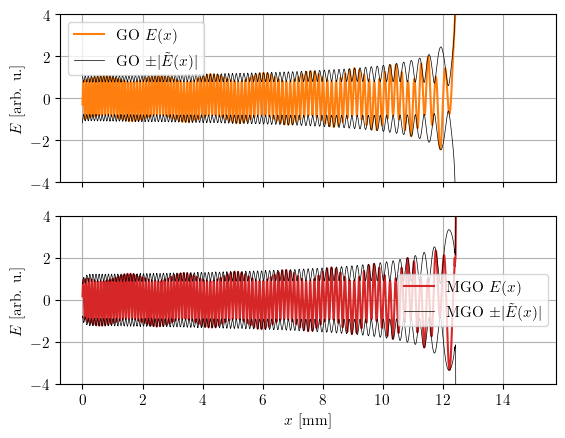

In [90]:
xi = np.linspace(0, 15e-3, 6000)
fig = plt.figure(constrained_layout=True, figsize=(17*cm, 12*cm))

fig, ax = plt.subplots(2, 1)
ax[0].plot(xi*1e3, np.real(go_field_lin(xi)), '-', color='tab:orange', label=r'GO $E(x)$')
ax[0].plot(xi*1e3, np.abs(go_field_lin(xi)), 'k-', linewidth=0.5, label=r'GO $\pm |\tilde{E}(x)|$')
ax[0].plot(xi*1e3, -np.abs(go_field_lin(xi)), 'k-', linewidth=0.5)
ax[0].grid()
ax[0].legend()
# ax[0].set_xlim(0, xs[i_start+i_caust]*1e3)
ax[0].sharex(ax[1])
ax[0].tick_params('x', labelbottom=False)
ax[0].set_ylim(-4, 4)
ax[0].set_ylabel(r'$E$ [arb. u.]')

ax[1].plot(xi*1e3, np.real(mgo_field_lin(xi)), color='tab:red', label=r'MGO $E(x)$')
ax[1].plot(xi*1e3, np.abs(mgo_field_lin(xi)), 'k-', linewidth=0.5, label=r'MGO $\pm |\tilde{E}(x)|$')
ax[1].plot(xi*1e3, -np.abs(mgo_field_lin(xi)), 'k-', linewidth=0.5)
ax[1].grid()
ax[1].legend()
# ax[1].set_xlim(0, xs[i_start+i_caust]*1e3)
ax[1].set_ylim(-4, 4)
ax[1].set_xlabel(r'$x$ [mm]')
ax[1].set_ylabel(r'$E$ [arb. u.]')

plt.show()